In [38]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import random
from geopy.geocoders import Nominatim
import io
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# Verzamelen van Toegangstoken
In dit blok halen we een toegangstoken op voor de verbinding met de Sentinel Hub API. Dit token wordt later gebruikt om gegevens op te vragen.

In [39]:
CLIENT_ID = "cbd517e2-9cc3-45eb-9676-b7d819396197"
CLIENT_SECRET = "cE9yVPSLYDCON304gWDfZeDjLYE9SlpL"

# Set up credentials
client = BackendApplicationClient(client_id=CLIENT_ID)
oauth = OAuth2Session(client=client)

# Verkrijg het toegangstoken
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/auth/realms/main/protocol/openid-connect/token',
                          client_secret=CLIENT_SECRET, include_client_id=True)


# Genereren van een Willekeurige Bounding Box en Locatie
Genereren van willekeurige bounding box binnen gespecificeerde geografische grenzen en haalt de bijbehorende locatie-naam op.

In [40]:
# Functie om een willekeurige bounding box binnen een bepaald gebied te genereren
def generate_random_bbox(lat_min, lat_max, lon_min, lon_max, max_size_deg=1.0):
    lat1 = random.uniform(lat_min, lat_max)
    lon1 = random.uniform(lon_min, lon_max)

    # Beperk de grootte van de bounding box
    lat2 = lat1 + random.uniform(-max_size_deg, max_size_deg)
    lon2 = lon1 + random.uniform(-max_size_deg, max_size_deg)
    
    bbox = [min(lon1, lon2), min(lat1, lat2), max(lon1, lon2), max(lat1, lat2)]
    return bbox

# Functie om de locatie-naam te verkrijgen via Geopy (Nominatim)
def get_location_name(lat, lon):
    geolocator = Nominatim(user_agent="random_bbox_app")
    location = geolocator.reverse((lat, lon), language='en')
    return location.address if location else "Onbekende locatie"

# Specificeer de grenzen voor willekeurige coördinaten (bijvoorbeeld voor Europa)
lat_min = 40.0  # Minimum breedtegraad
lat_max = 60.0  # Maximum breedtegraad
lon_min = 45.0  # Minimum lengtegraad
lon_max = 80.0  # Maximum lengtegraad

# Genereer een willekeurige bounding box
bbox_random = generate_random_bbox(lat_min, lat_max, lon_min, lon_max)
print(f"Willekeurige Bounding Box: {bbox_random}")

# Verkrijg de locatie-naam voor het middelpunt van de bounding box
center_lat = (bbox_random[1] + bbox_random[3]) / 2
center_lon = (bbox_random[0] + bbox_random[2]) / 2
location_name = get_location_name(center_lat, center_lon)

print(f"Locatie van het centrum van de bounding box: {location_name}")

# Print de coördinaten van het middelpunt
print(f"Centrum coördinaten: Breedtegraad {center_lat}, Lengtegraad {center_lon}")

Willekeurige Bounding Box: [51.24301536962368, 49.35428968754242, 51.80024127487831, 49.60948334942121]
Locatie van het centrum van de bounding box: Ақсуат ауылдық округі, Akzhaik District, West Kazakhstan Region, Kazakhstan
Centrum coördinaten: Breedtegraad 49.481886518481815, Lengtegraad 51.52162832225099


# Verzoek naar Sentinel Hub API voor Satellietdata
Een verzoek maken naar de Sentinel Hub API om satellietafbeeldingen te verkrijgen voor een willekeurige bounding box. Het haalt de data op in de vorm van een composietafbeelding met de banden voor rood, groen, blauw en nabij-infrarood.

In [41]:
def fetch_images_for_training(bbox, start_date, end_date, num_images=10):
    images = []
    collection_id = "sentinel-2-l2a"

    evalscript = """
    //VERSION=3
    function setup() {
        return {
            input: ["B04", "B03", "B02", "B08"],  // Voeg B8 (NIR) toe
            output: {
                bands: 4,
                sampleType: "AUTO"
            }
        }
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02, sample.B08]; // Retourneer de juiste banden
    }
    """

    # Haal meerdere afbeeldingen op
    for i in range(num_images):
        json_request = {
            'input': {
                'bounds': {
                    'bbox': bbox,
                    'properties': {
                        'crs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84'
                    }
                },
                'data': [
                    {
                        'type': collection_id,
                        'dataFilter': {
                            'timeRange': {
                                'from': start_date,
                                'to': end_date
                            },
                            'mosaickingOrder': 'leastCC',
                        },
                    }
                ]
            },
            'output': {
                'width': 1024,
                'height': 1024,
                'responses': [
                    {
                        'identifier': 'default',
                        'format': {
                            'type': 'image/tiff',
                        }
                    }
                ]
            },
            'evalscript': evalscript
        }

        url_request = "https://services.sentinel-hub.com/api/v1/process"
        headers_request = {
            "Authorization": f"Bearer {token['access_token']}"
        }
        response = oauth.request("POST", url_request, headers=headers_request, json=json_request)

        if response.status_code == 200:
            print(f"Afbeelding {i+1} succesvol opgehaald!")
            img_data = response.content
            images.append(img_data)
        else:
            print(f"Fout bij API-aanroep voor afbeelding {i+1}: {response.status_code}")
            print(response.text)
    
    return images

# Haal 10 afbeeldingen op voor training
start_date = "2023-01-01T00:00:00Z"  # Gebruik het ISO-8601 formaat inclusief tijd en tijdzone
end_date = "2023-06-01T00:00:00Z"    # Gebruik het ISO-8601 formaat inclusief tijd en tijdzone
images = fetch_images_for_training(bbox_random, start_date, end_date, num_images=10)

Afbeelding 1 succesvol opgehaald!
Afbeelding 2 succesvol opgehaald!
Afbeelding 3 succesvol opgehaald!
Afbeelding 4 succesvol opgehaald!
Afbeelding 5 succesvol opgehaald!
Afbeelding 6 succesvol opgehaald!
Afbeelding 7 succesvol opgehaald!
Afbeelding 8 succesvol opgehaald!
Afbeelding 9 succesvol opgehaald!
Afbeelding 10 succesvol opgehaald!


# Verwerken en Visualiseren van Satellietdata
De ontvangen satellietdata openen, de banden van de afbeelding geëxtraheerd en de NDVI (Normalized Difference Vegetation Index) berekend. Vervolgens worden de originele afbeelding en de NDVI-uitvoer gevisualiseerd.

In [42]:
def calculate_ndvi(img_data):
    with rasterio.open(io.BytesIO(img_data)) as src:
        red_band = src.read(1)  # B4
        green_band = src.read(2)  # B3
        blue_band = src.read(3)  # B2
        nir_band = src.read(4)  # B8
        
    # Normaliseer de banden
    red_band_normalized = red_band / 255.0
    nir_band_normalized = nir_band / 255.0  # Normaliseer de NIR-band

    # Bereken de NDVI
    denominator = nir_band_normalized + red_band_normalized
    denominator[denominator == 0] = np.nan  # Zet nulwaarden om in NaN
    ndvi = (nir_band_normalized - red_band_normalized) / denominator
    
    # Vervang NaN en inf waarden door -1 (water maskeren)
    ndvi = np.nan_to_num(ndvi, nan=-1, posinf=-1, neginf=-1)
    
    return ndvi

# Bereken de NDVI voor alle afbeeldingen
ndvi_images = [calculate_ndvi(img_data) for img_data in images]

# Machine Learning Model voor NDVI Voorspelling
Random Forest-regressor gebruiken om de NDVI te voorspellen op basis van de bestaande kenmerken van de afbeelding.

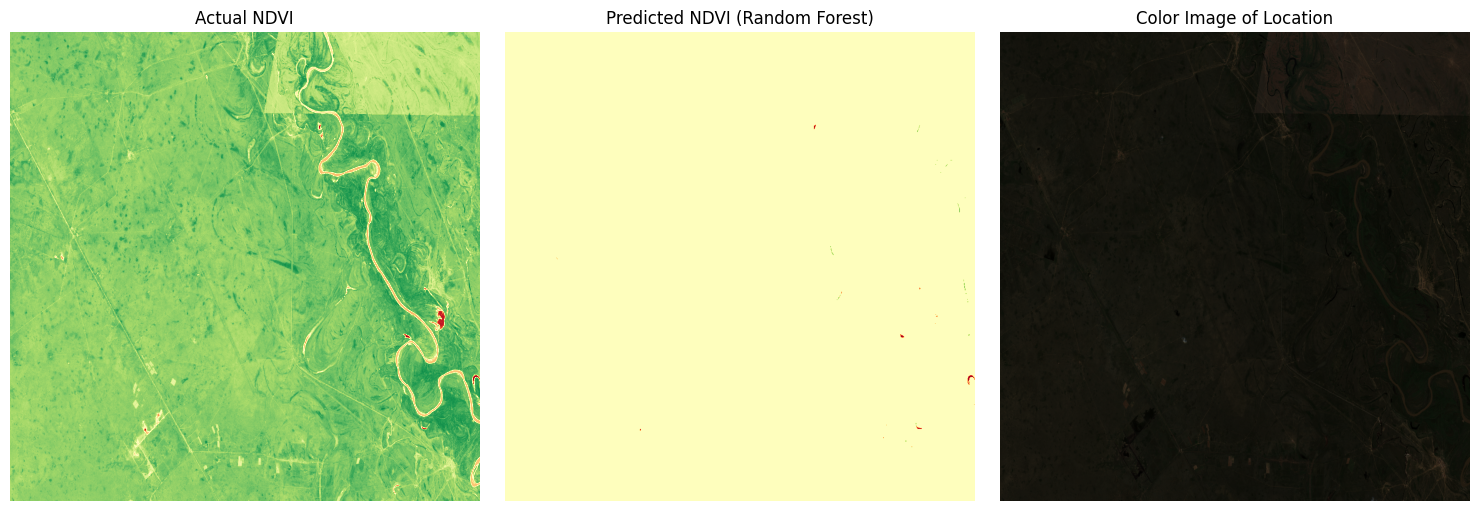

Mean Absolute Error: 3.8931647353177744e-10


In [43]:
# Functie om de gekleurde afbeelding te creëren (RGB)
def create_color_image(img_data):
    with rasterio.open(io.BytesIO(img_data)) as src:
        red_band = src.read(1)  # B4
        green_band = src.read(2)  # B3
        blue_band = src.read(3)  # B2
    
    # Combineer de banden in een RGB-kleurbeeld
    color_image = np.stack([red_band, green_band, blue_band], axis=-1)
    
    # Normaliseer de kleuren naar 0-255
    color_image = np.clip(color_image, 0, 255).astype(np.uint8)
    
    return color_image

# Train the Random Forest Regressor
X_train = []
y_train = []

# Loop door de eerste 9 afbeeldingen (exclude de laatste afbeelding voor training)
for ndvi in ndvi_images[:-1]:
    mask_water = (ndvi == -1)  # Watergebieden
    ndvi_non_water = ndvi[~mask_water]  # Alleen niet-watergebieden

    X_train.extend(ndvi_non_water)
    y_train.extend(ndvi_non_water)

X_train = np.array(X_train).reshape(-1, 1)  # Features voor training
y_train = np.array(y_train)  # Labels voor training

# Split de data in train- en test-sets
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train het Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_split, y_train_split)

# Gebruik de laatste afbeelding voor voorspellingen
latest_ndvi = ndvi_images[-1]
mask_water = (latest_ndvi == -1)
latest_ndvi_non_water = latest_ndvi[~mask_water].reshape(-1, 1)  # Alleen niet-watergebieden

# Voorspel de niet-water NDVI waarden
y_pred = rf_model.predict(latest_ndvi_non_water)

# Maak een lege array voor de voorspelde NDVI
predicted_ndvi = np.full(latest_ndvi.shape, -1)  # Begin met -1 voor watergebieden
predicted_ndvi[~mask_water] = y_pred  # Vul de niet-watergebieden met de voorspellingen

# Maak de gekleurde afbeelding van de locatie (RGB)
color_image = create_color_image(images[-1])

# Plot de afbeeldingen
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Visualiseer de werkelijke NDVI van de laatste afbeelding
axs[0].imshow(latest_ndvi, cmap='RdYlGn')
axs[0].set_title('Actual NDVI')
axs[0].axis('off')  # Verberg de assen

# Visualiseer de voorspelde NDVI
axs[1].imshow(predicted_ndvi, cmap='RdYlGn')
axs[1].set_title('Predicted NDVI (Random Forest)')
axs[1].axis('off')

# Visualiseer de gekleurde afbeelding van de locatie
axs[2].imshow(color_image)
axs[2].set_title('Color Image of Location')
axs[2].axis('off')

plt.tight_layout()
plt.show()

# Bereken de Mean Absolute Error (MAE) voor de voorspelling
mae = mean_absolute_error(latest_ndvi_non_water, y_pred)
print(f"Mean Absolute Error: {mae}")

In [44]:
# Genereer de Google Maps link in decimale graden
google_maps_link = f"https://www.google.com/maps?q={center_lat},{center_lon}"

# Print de link
print(f"Bekijk de locatie op Google Maps: {google_maps_link}")


Bekijk de locatie op Google Maps: https://www.google.com/maps?q=49.481886518481815,51.52162832225099
